In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import plotly.express as ex

from tqdm.cli import tqdm
from glob import glob
from sklearn.manifold import TSNE
from plotly import express as ex
from os import path as pathlib,walk

%matplotlib inline

In [64]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,Callback

In [65]:
class Dataset(object):
    """
    Dataset wrapper to read images from folder and structure it.
    """
    def __init__(self,path,n_faces,resize=128):
        self.path = pathlib.abspath(path)
        self.resize = resize

    def __repr__(self,):
        return f"Dataset Parser @ {self.path}"
        
    def parse(self,progress_bar=True):
        w = walk(self.path)
        self.data = np.array([[[r,pathlib.join(r,f_)] for f_ in f] for r,_,f in list(w)[1:]]).reshape(-1,2)
        self.y = np.array(self.data[:,0])
        self.x = np.array([
            cv2.cvtColor(
                cv2.resize(
                    cv2.imread(
                        i
                    ),
                    (self.resize,self.resize)
                ),
                cv2.COLOR_BGR2RGB
            ) / 255
            for 
                i
            in 
                (tqdm(self.data[:,1]) if progress_bar else self.data[:,1])
        ]).astype(np.float32).mean(axis=-1).reshape(-1, 128, 128, 1)
        return self
            

In [66]:
dataset = Dataset("./images/train/",200)

In [67]:
dataset.parse(progress_bar=1)

100%|██████████| 450/450 [00:00<00:00, 744.29it/s]


Dataset Parser @ /storage/facedet_cap/notebooks/images/train

### Base Network

In [92]:
class LargeTanH(keras.layers.Layer):
    def call(self,x):
        x = tf.math.tanh(x)
        x = tf.multiply(x, 64)
        return x

In [93]:
def conv(x, filters, kernel_size=3):
    x = Conv2D( filters, kernel_size, padding='same', )(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    return x
    
def block(x, filters, ):
    dx = conv(x, filters, )    
    x = Concatenate()([ x, dx ])
    x = conv(x, filters, 1)
    x = MaxPool2D()(x)
    
    return x

def base_network(d=64):

    im_in = Input(shape=(128,128,1))
    
    b1 = block( im_in, 32 )
    b2 = block( b1, 64 )
    b3 = block( b2, 128 )
    b4 = block( b3, 256 )
    
    out = GlobalAveragePooling2D()(b4)
    out = Dense(1024, )(out)
    out = BatchNormalization()(out)
    out = Activation('tanh')(out)
    out = Dense( d, )(out)
    out = BatchNormalization()(out)
    out = LargeTanH()(out)
    
    model = keras.Model(im_in,out)
    
    return model

In [94]:
class Pairs(object):
    def __init__(self,model:tf.keras.Model,x:np.ndarray,y:np.ndarray,size:int=128):
        self.x = x.reshape(-1,size, size,1) 
        self.y = y
        self.dummy = np.array([[0]])
        
        self.model = model
        self.size = size
        
    def generate_pairs(self,):
        pass
    
    def flow(self,):
        while True:
            emb = self.model.predict(self.x)
            score = tf.math.abs(tf.reduce_mean(emb - tf.reshape(emb, shape=(-1, 1, 64)), axis=-1)).numpy()
            ps = []
            for a,( dy , de ) in enumerate(zip(self.y,score)):
                p_index, = np.where( self.y == dy )
                n_index, = np.where( self.y != dy )
                p = p_index[de[p_index].argmax()]
                n = n_index[de[n_index].argmin()]
                ps.append((a,p,n))
                
            ps = np.array(ps).reshape(-1,10,3)
            np.random.shuffle(ps)
            for idx in ps:
                yield ( self.x[idx[:,0]], self.x[idx[:,1]], self.x[idx[:,2]] ), self.dummy            

In [95]:
model = base_network()
pairs = Pairs(model,dataset.x,dataset.y)
flow = pairs.flow()

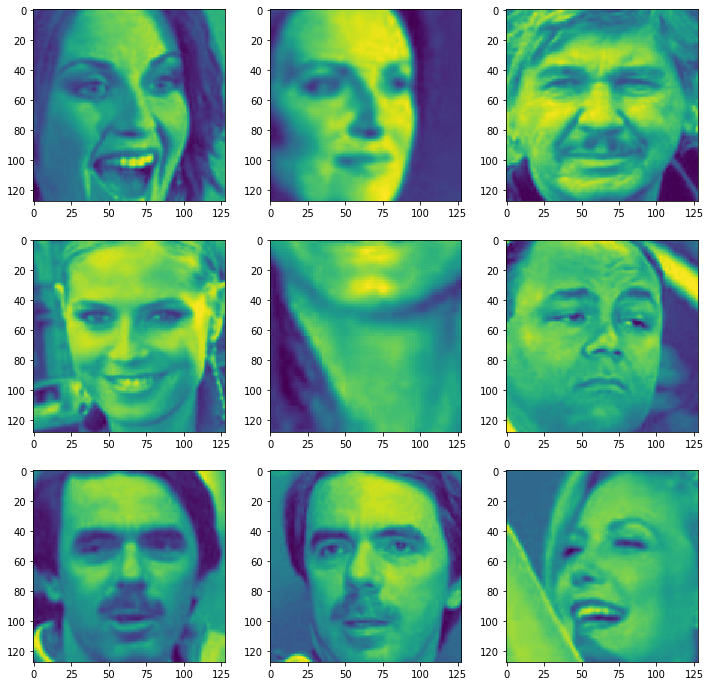

In [96]:
fig,axes = plt.subplots(3,3,figsize=(12,12))

for ax in axes:
    (a,p,n),r = next(flow)
    ax[0].imshow(a[0].reshape(128, 128))
    ax[1].imshow(p[0].reshape(128, 128))
    ax[2].imshow(n[0].reshape(128, 128))

In [97]:
class Triplet(tf.Module):
    """
    Triplet Loss
    """
    __name__ = "TripletLoss"
    def __init__(self,d,margin=.75):
        self.d = d
        self.margin = margin
        self.l2 = keras.losses.MeanAbsoluteError()
 
    @tf.function
    def __call__(self,y_true,y_pred,*args,**kwargs):
        a,p,n = tf.unstack(tf.reshape(y_pred,(3,-1,self.d)))
        Dp = self.l2(a,p)
        Dn = self.l2(a,n)
        return tf.nn.relu(Dp - Dn + self.margin)

In [98]:
class EpochOutputSave(Callback):
    tsne = TSNE(2)
    def on_epoch_end(self,epoch,log,*args,**kwrags):
        p = model.predict(x,batch_size=5)
        a = self.tsne.fit_transform(p)
        fig = plt.figure(figsize=(13,10))
        sns.scatterplot(a[:,0],a[:,1],hue=y)
        plt.legend("off")
        plt.title(f"epoch : {epoch} | loss : {log['loss']}")
        fig.savefig(f"../doc/epoch/facenet/{epoch}.jpg")
        plt.close()   
        
class EpochHandler(Callback):
    def __init__(self):
        self.loss_history = [*list(range(5))]
        
    def on_epoch_end(self,epoch,logs=dict()):
        epoch_loss = logs.get('loss')
        self.loss_history.append(epoch_loss)
        if sum(self.loss_history[-3:]) == 0:
            self.model.stop_training = True 
            print (f"Stopped Training At {epoch} Epochs.")

In [99]:
model = base_network()

a_inp = Input(shape=(128, 128,1),name="anc")
p_inp = Input(shape=(128, 128,1),name="pos")
n_inp = Input(shape=(128, 128,1),name="neg")

a_net = model(a_inp)
p_net = model(p_inp)
n_net = model(n_inp)

out = concatenate([a_net,p_net,n_net],name="out")
train = keras.Model([a_inp,p_inp,n_inp],out)

In [100]:
ckp = ModelCheckpoint(filepath="./checkpoints/facenet",save_weights_only=True)
save = EpochOutputSave()
eh = EpochHandler()

opt = keras.optimizers.Adagrad(.0001)
triplet = Triplet(d=64,margin=8)

train.compile(optimizer=opt,loss=triplet)

In [101]:
epochs = 300

pairs = Pairs(model,dataset.x,dataset.y)
flow = pairs.flow()

In [102]:
history = train.fit_generator(flow,steps_per_epoch=120,epochs=epochs,callbacks=[eh])

Epoch 1/300
120/120 [==============================] - 15s 96ms/step - loss: 8.8263
Epoch 2/300
120/120 [==============================] - 12s 99ms/step - loss: 8.2806
Epoch 3/300
120/120 [==============================] - 12s 96ms/step - loss: 6.0795
Epoch 4/300
120/120 [==============================] - 12s 96ms/step - loss: 5.7796
Epoch 5/300
120/120 [==============================] - 12s 99ms/step - loss: 4.7607
Epoch 6/300
120/120 [==============================] - 12s 96ms/step - loss: 4.2087
Epoch 7/300
120/120 [==============================] - 12s 96ms/step - loss: 4.0881
Epoch 8/300
120/120 [==============================] - 12s 99ms/step - loss: 3.7856
Epoch 9/300
120/120 [==============================] - 11s 96ms/step - loss: 3.6266
Epoch 10/300
120/120 [==============================] - 12s 96ms/step - loss: 3.4606
Epoch 11/300
120/120 [==============================] - 12s 99ms/step - loss: 2.6461
Epoch 12/300
120/120 [==============================] - 11s 96ms/step - lo

In [103]:
p = model.predict(dataset.x,batch_size=10)

In [104]:
tsne = TSNE(2,)
a = tsne.fit_transform(p)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Final Output')

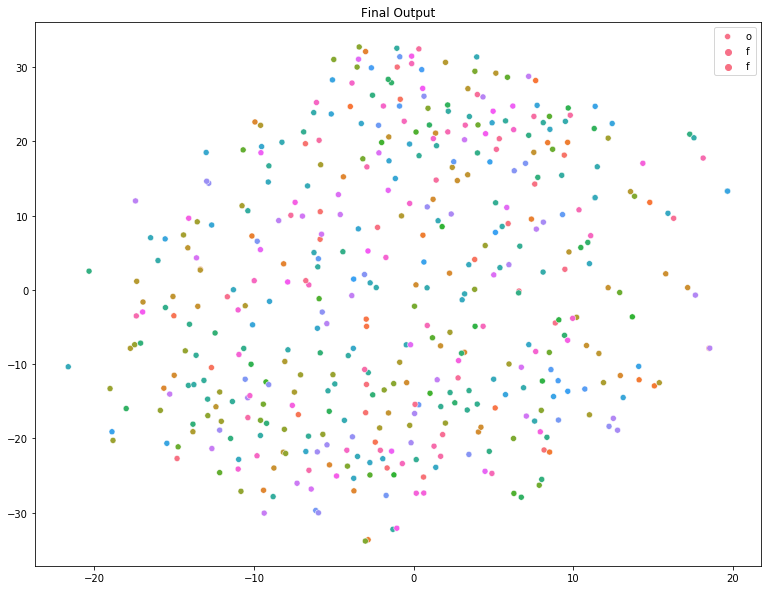

In [105]:
fig = plt.figure(figsize=(13,10))
sns.scatterplot(a[:,0],a[:,1],hue=dataset.y,)
plt.legend("off")
plt.title("Final Output")

In [106]:
p.shape

(450, 64)